In [ ]:
'''
=====================================================
🚀 Lung Cancer Classification Project
=====================================================

🔹 Steps for Custom CNN (Deep Learning)
=====================================================

1. Dataset Preparation
   - Load IQ-OTHNCCD lung cancer dataset (Normal, Benign, Malignant cases)
   - Convert images to grayscale & resize (128x128)
   - Normalize pixel values (0–1)
   - Split into training and validation sets

2. Dataset & DataLoader (PyTorch)
   - Create a custom Dataset class
   - Apply augmentation (flips, rotations)
   - Use DataLoader for batching

3. Define Custom CNN Model
   - Convolutional layers for feature extraction
   - Pooling layers to reduce dimensions
   - Fully connected layers + final output layer (3 classes)

4. Training Loop
   - Forward pass
   - Compute loss (CrossEntropyLoss)
   - Backpropagation using Adam optimizer
   - Track training accuracy and loss

5. Validation
   - Evaluate on validation set each epoch
   - Record validation accuracy and loss

6. Evaluation
   - Confusion matrix
   - Classification report (Precision, Recall, F1-score)

7. Visualization
   - Training & validation loss/accuracy curves
   - Optional: Grad-CAM heatmaps for interpretability

8. Save Model
   - Save trained weights as .pth file
'''


In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [3]:
# dataset path (adjust to your system)
!pip install kagglehub

import kagglehub, os

# Download IQ-OTHNCCD Lung Cancer Dataset
path = kagglehub.dataset_download("adityamahimkar/iqothnccd-lung-cancer-dataset")
print("Dataset downloaded to:", path)

# Define dataset paths
DATA_DIR = os.path.join(path, "The IQ-OTHNCCD lung cancer dataset", "The IQ-OTHNCCD lung cancer dataset")
OUT_DIR = "data/processed_rf"
os.makedirs(OUT_DIR, exist_ok=True)

print("DATA_DIR:", DATA_DIR)
print("OUT_DIR:", OUT_DIR)

label_map = {
    "Normal cases": 0,
    "Bengin cases": 1,
    "Malignant cases": 2
}

IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 10
device = "cuda" if torch.cuda.is_available() else "cpu"


In [5]:
all_data = []
for cls, label in label_map.items():
    folder = os.path.join(DATA_DIR, cls)
    for fname in tqdm(os.listdir(folder), desc=cls):
        if fname.lower().endswith(".jpg"):
            path = os.path.join(folder, fname)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img.astype(np.float32) / 255.0
            save_name = f"{cls}_{fname.replace(' ','_')}.npz"
            np.savez_compressed(os.path.join(OUT_DIR, save_name),
                                image=img, label=label)
            all_data.append([save_name, label])

df = pd.DataFrame(all_data, columns=["file","label"])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

train_df = df.sample(frac=0.8, random_state=42)
val_df = df.drop(train_df.index)

train_df.to_csv(os.path.join(OUT_DIR,"train.csv"), index=False)
val_df.to_csv(os.path.join(OUT_DIR,"val.csv"), index=False)

print("Train size:", len(train_df), "Val size:", len(val_df))


Malignant cases: 100%|███████████████████████| 561/561 [00:02<00:00, 255.32it/s]

Train size: 878 Val size: 219


In [7]:
class LungCancerDataset(Dataset):
    def __init__(self, csv_file, root_dir, augment=False):
        self.df = pd.read_csv(csv_file)
        self.root = root_dir
        self.augment = augment

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        data = np.load(os.path.join(self.root, row['file']))
        x = np.expand_dims(data['image'], axis=0).astype(np.float32)
        y = int(data['label'])
        if self.augment:
            if np.random.rand()<0.5: x = np.flip(x, axis=1).copy()
            if np.random.rand()<0.5: x = np.flip(x, axis=2).copy()
        return torch.tensor(x), torch.tensor(y, dtype=torch.long)

train_dataset = LungCancerDataset(os.path.join(OUT_DIR,"train.csv"), OUT_DIR, augment=True)
val_dataset   = LungCancerDataset(os.path.join(OUT_DIR,"val.csv"), OUT_DIR, augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

x,y = next(iter(train_loader))
print("Batch:", x.shape, "Labels:", y[:10])


Batch: torch.Size([32, 1, 128, 128]) Labels: tensor([0, 0, 2, 2, 0, 0, 2, 2, 2, 0])


In [21]:
!pip install torchinfo
import torch
import torch.nn as nn
from torchinfo import summary   # <-- add this

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*16*16, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# create model
model = SimpleCNN().to(device)

# get summary (like Keras style)
summary(model, input_size=(32, 1, 128, 128))  # batch=32, 1 channel, 128x128 images


Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [32, 3]                   --
├─Sequential: 1-1                        [32, 128, 16, 16]         --
│    └─Conv2d: 2-1                       [32, 32, 128, 128]        320
│    └─ReLU: 2-2                         [32, 32, 128, 128]        --
│    └─MaxPool2d: 2-3                    [32, 32, 64, 64]          --
│    └─Conv2d: 2-4                       [32, 64, 64, 64]          18,496
│    └─ReLU: 2-5                         [32, 64, 64, 64]          --
│    └─MaxPool2d: 2-6                    [32, 64, 32, 32]          --
│    └─Conv2d: 2-7                       [32, 128, 32, 32]         73,856
│    └─ReLU: 2-8                         [32, 128, 32, 32]         --
│    └─MaxPool2d: 2-9                    [32, 128, 16, 16]         --
├─Sequential: 1-2                        [32, 3]                   --
│    └─Flatten: 2-10                     [32, 32768]               --
│    └

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    # Train
    model.train()
    total_loss, correct, total = 0,0,0
    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs,y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()*x.size(0)
        _,preds = outputs.max(1)
        correct += (preds==y).sum().item()
        total += y.size(0)
    train_losses.append(total_loss/total)
    train_accs.append(correct/total)

    # Val
    model.eval()
    total_loss, correct, total = 0,0,0
    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs,y)
            total_loss += loss.item()*x.size(0)
            _,preds = outputs.max(1)
            correct += (preds==y).sum().item()
            total += y.size(0)
    val_losses.append(total_loss/total)
    val_accs.append(correct/total)

    print(f"Epoch {epoch+1}/{EPOCHS}: Train Acc {train_accs[-1]:.4f}, Val Acc {val_accs[-1]:.4f}")


Epoch 1/10: Train Acc 0.5057, Val Acc 0.5342
Epoch 2/10: Train Acc 0.5604, Val Acc 0.5753
Epoch 3/10: Train Acc 0.6310, Val Acc 0.6027
Epoch 4/10: Train Acc 0.6708, Val Acc 0.5890
Epoch 5/10: Train Acc 0.6936, Val Acc 0.6758
Epoch 6/10: Train Acc 0.7187, Val Acc 0.6849
Epoch 7/10: Train Acc 0.7369, Val Acc 0.6895
Epoch 8/10: Train Acc 0.7437, Val Acc 0.6758
Epoch 9/10: Train Acc 0.7472, Val Acc 0.7215
Epoch 10/10: Train Acc 0.7494, Val Acc 0.7169


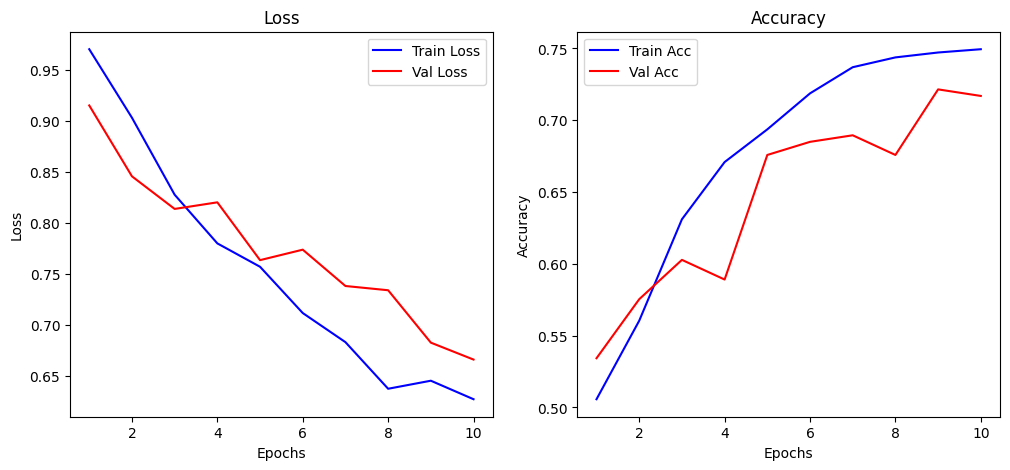

In [12]:
epochs = range(1,EPOCHS+1)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, 'b-', label="Train Loss")
plt.plot(epochs, val_losses, 'r-', label="Val Loss")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(epochs, train_accs, 'b-', label="Train Acc")
plt.plot(epochs, val_accs, 'r-', label="Val Acc")
plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy")

plt.show()


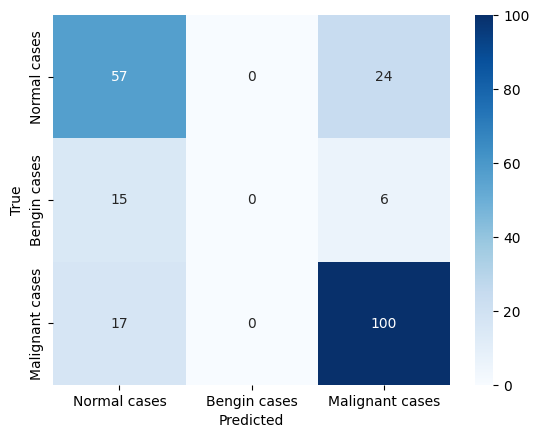

                 precision    recall  f1-score   support

   Normal cases       0.64      0.70      0.67        81
   Bengin cases       0.00      0.00      0.00        21
Malignant cases       0.77      0.85      0.81       117

       accuracy                           0.72       219
      macro avg       0.47      0.52      0.49       219
   weighted avg       0.65      0.72      0.68       219



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for x,y in val_loader:
        x,y = x.to(device), y.to(device)
        preds = model(x).argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(label_map.keys()),
            yticklabels=list(label_map.keys()))
plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

print(classification_report(all_labels, all_preds, target_names=list(label_map.keys())))


In [ ]:
torch.save(model.state_dict(), "lung_customcnn.pth")
print("Custom CNN model saved!")


In [ ]:
'''
=====================================================
🔹 Comparison of Models for Lung Cancer Classification
=====================================================

1. Random Forest (Classical ML)
-----------------------------------------------------
- Input: Flattened grayscale images (e.g., 64x64 → 4096 features)
- Feature Learning: No automatic feature learning → model sees raw pixel values
- Training Time: Fast (on CPU)
- Accuracy: Moderate (depends on image quality and preprocessing)
- Pros:
  * Simple and easy to train
  * Works well on small datasets
  * No need for GPU
- Cons:
  * Cannot capture spatial image patterns well
  * Limited accuracy compared to deep learning

2. Custom CNN (Deep Learning from Scratch)
-----------------------------------------------------
- Input: Grayscale images (e.g., 128x128)
- Feature Learning: Learns filters automatically (edges, textures, shapes)
- Training Time: Moderate (needs GPU for faster training)
- Accuracy: Better than Random Forest if dataset is large enough
- Pros:
  * Learns useful image features directly
  * End-to-end pipeline (raw image → classification)
  * Flexible and customizable
- Cons:
  * Needs more data than Random Forest
  * Risk of overfitting if dataset is small
  * Training is slower than Random Forest

3. ResNet (Transfer Learning with Pretrained Model)
-----------------------------------------------------
- Input: Resized images (128x128 or 224x224)
- Feature Learning: Uses pretrained convolutional layers (from ImageNet)
- Training Time: Longer per epoch, but fewer epochs needed
- Accuracy: Highest among the three (best generalization)
- Pros:
  * Pretrained weights → works even on small datasets
  * Residual connections → stable training for deep networks
  * Usually state-of-the-art accuracy
- Cons:
  * Requires GPU and more compute resources
  * Model size is larger (more parameters)

=====================================================
🔹 Summary
-----------------------------------------------------
- Random Forest → Fast, simple, good baseline
- Custom CNN   → Learns features from scratch, better than RF if enough data
- ResNet       → Most powerful, best accuracy, benefits from transfer learning
=====================================================
'''
